In [4]:
""" Plot the output of a random network to visualize
    smoothness as done in Ramachandran et al. 2017 to gain
    intuition about different e-swish variants. 
"""

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K 
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Optimizer
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import TensorBoard, EarlyStopping

In [5]:
# Different activations to test<

# Swish activation function
# x*sigmoid(x)
def swish(x):
    return x*K.sigmoid(x)

# Custom activation function 1
# mix between relu and positive part of swish mirrored across x=1
def e_swish_1(x):
    return K.maximum(0.0, x*(2-K.sigmoid(x)))

# Custom activation function 2
# positive part of swish mirrored across x=1
def e_swish_2(x):
    return K.maximum(x*K.sigmoid(x), x*(2-K.sigmoid(x)))

# Custom activation function 3 - Hand designed
# e_swish_2 made derivable
def e_swish_3(x):
    return K.maximum(6*K.sigmoid(x)*(1-K.sigmoid(x))*x*K.sigmoid(x), x*(2-K.sigmoid(x)))

# Custom activation function 4 - Reduced operations for e_swish_3 
# e_swish_2 made derivable (more similar to swish in the negative part)
def e_swish_4(x):
    return K.maximum((1+0.25/(K.exp(K.abs(x))-0.5))*x*K.sigmoid(x), x*(2-K.sigmoid(x)))

def leaky_relu(x):
    return K.maximum(0.3*x,x)

In [6]:
a, res= 100, 1 # Area and resolution
x = np.array([[(i)/res, (j)/res] for i in range(-a, +a) for j in range(-a, +a)])
print(x.shape)

(40000, 2)


In [7]:
def create_model(act, l):
    np.random.seed(42)
    tf.set_random_seed(42)
    # with tf.device('/cpu:0'): # Makes it more deterministic (CuDNN indetermination)
    model = Sequential()
    model.add(Dense(128, activation=act, input_dim=2))
    for i in range(l):
        model.add(Dense(128, activation=act, kernel_initializer='random_normal', bias_initializer='zeros'))
    model.add(Dense(1, activation=act))

    model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
    return model

In [12]:
activations = [e_swish_2,  swish, "relu", leaky_relu, "linear", "elu"] #e_swish_1, e_swish_3,  e_swish_4,
names = activations[:]
for i,act in enumerate(names):
    if not isinstance(act, str):
        names[i] = act.__name__
print(names)
names[0] = "e_swish"

['e_swish_2', 'swish', 'relu', 'leaky_relu', 'linear', 'elu']


<IPython.core.display.Javascript object>


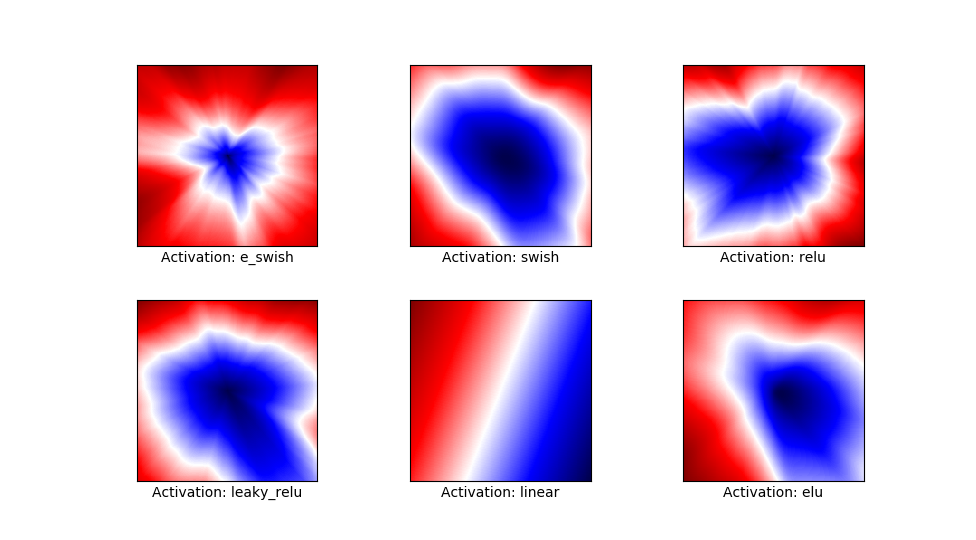

e_swish
swish
relu
leaky_relu
linear
elu


In [13]:
%matplotlib notebook
def show(activations, names):
 # Create a 3*3 figure to display images.
    fig, axes = plt.subplots(2,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        try:
            # Create the model
            act, act_name = activations[i], names[i]
            model = create_model(act,5)
            pred = model.predict(x)
            # Print image.
            ax.imshow(pred.reshape(2*a,2*a), cmap="seismic")
            # Set labels
            xlabel = "Activation: {}".format(act_name)
            ax.set_xlabel(xlabel)
            print(act_name)
        except: pass
        # Remove x and y axis.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

show(activations, names)

In [9]:
a, res= 50, 1 # Area and resolution
x = np.array([[(i)/res, (j)/res] for i in range(-a, +a) for j in range(-a, +a)])
print(x.shape)

(10000, 2)


In [14]:
preds = []
for i, act in enumerate(["relu", "elu", swish, e_swish_2]):
    model = create_model(act,5)
    pred = model.predict(x).flatten()
    # Rescale to unit variance
    pred = pred/np.std(pred)
    preds.append(pred)
    print(i)

0
1
2
3


In [15]:
prep = []
for pred in preds:
    prep.append(sorted(list(pred)))

<IPython.core.display.Javascript object>


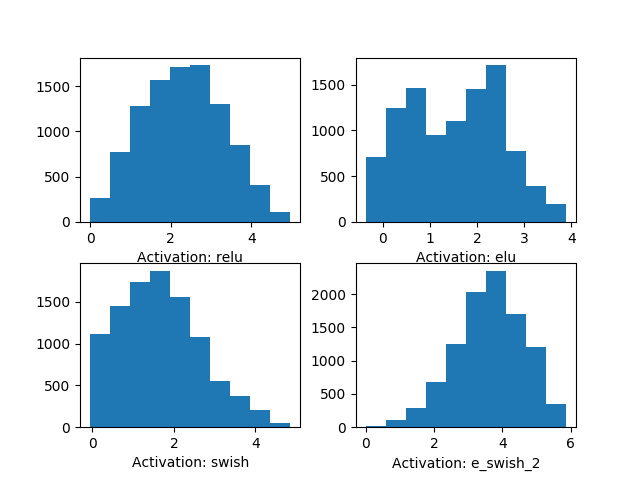

Mean of relu: 2.31283
Mean of elu: 1.51489
Mean of swish: 1.67236
Mean of e_swish_2: 3.62151


In [16]:
dists = ["relu", "elu", "swish", "e_swish_2"]

fig, axes = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.25, wspace=0.25)

for i, ax in enumerate(axes.flat):
    # Print image.
    ax.hist(prep[i])
    # Set labels
    xlabel = "Activation: {}".format(dists[i])
    ax.set_xlabel(xlabel)

plt.show()
for i, p in enumerate(prep):
    print("Mean of "+dists[i]+":", np.mean(p))

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.datasets import cifar10

num_classes = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [28]:
baseMapNum = 32
weight_decay = 1e-4

model = Sequential()
model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation(act))
model.add(BatchNormalization())
model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation(act))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation(act))
model.add(BatchNormalization())
model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation(act))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation(act))
model.add(BatchNormalization())
model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation(act))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [41]:
recap = []
for d in dists:
    model.load_weights("../CIFAR10/models/cifar10_normal_rms_ep185"+d+".h5")
    weights = model.get_weights()[0][0, 0, :].flatten()
    recap.append(weights)

In [42]:
# print(weights)
print(recap)

[array([-0.01819098, -0.09345507,  0.05768485, -0.23008217,  0.09442557,
        0.04720069,  0.03015706,  0.14306062,  0.17362121, -0.11709774,
        0.21661113, -0.14161871,  0.14326993,  0.02708829,  0.24767002,
       -0.11363322, -0.12945998,  0.10460621, -0.1574782 ,  0.09389789,
       -0.16465162, -0.08217987,  0.04422788,  0.14223565,  0.16495088,
       -0.1437749 ,  0.13563107,  0.01802944,  0.15589926, -0.21430495,
       -0.14340311, -0.22021243, -0.14686294,  0.06879611, -0.08046092,
        0.12194189,  0.04910142, -0.19468564, -0.16621743, -0.05242877,
        0.05434124, -0.17226884,  0.15931636, -0.11415543,  0.05207994,
        0.00608242,  0.12504652, -0.01033063,  0.15580682,  0.0701031 ,
       -0.09413745, -0.15433715, -0.08547951, -0.18945998, -0.01910781,
       -0.26919559,  0.16338451, -0.05512602,  0.18085177, -0.13496985,
        0.07341341, -0.03336577, -0.02158077, -0.21602923,  0.11998509,
        0.01760656,  0.143282  ,  0.1172106 ,  0.198236  , -0.0

<IPython.core.display.Javascript object>


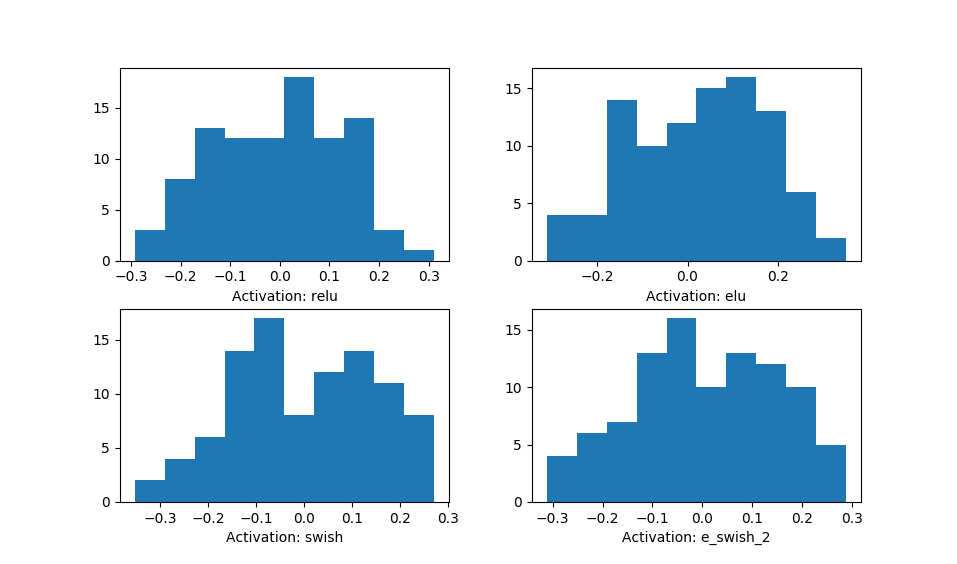

Mean of relu: -3.10656498186
Mean of elu: 21.8822006136
Mean of swish: 0.00771321356297
Mean of e_swish_2: 6.28070533276


In [44]:
fig, axes = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.25, wspace=0.25)

for i, ax in enumerate(axes.flat):
    # Print image.
    ax.hist(recap[i])
    # Set labels
    xlabel = "Activation: {}".format(dists[i])
    ax.set_xlabel(xlabel)

plt.show()
for i, p in enumerate(recap):
    print("Mean of "+dists[i]+":", np.mean(p)*1000)

<IPython.core.display.Javascript object>


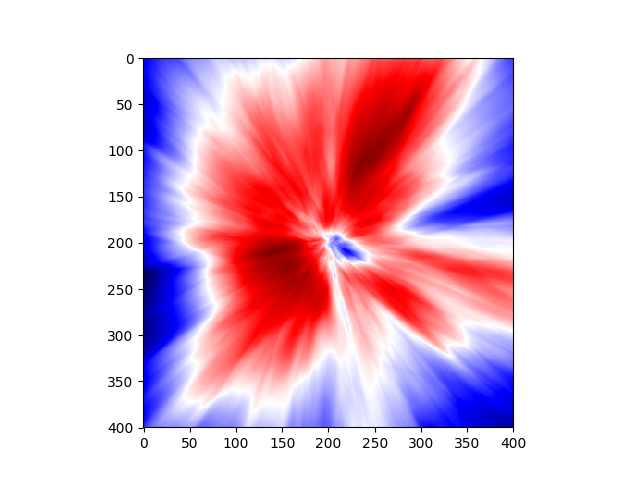

In [7]:
%matplotlib notebook
act, act_name = activations[2], names[2]
model = create_model(act,5)
pred_1 = model.predict(x)
act, act_name = activations[3], names[3]
model = create_model(act,5) 
pred_2 = model.predict(x)

diff = pred_2 - pred_1
plt.figure()
plt.imshow(diff.reshape(2*a,2*a), cmap="seismic_r")
plt.show()

<IPython.core.display.Javascript object>


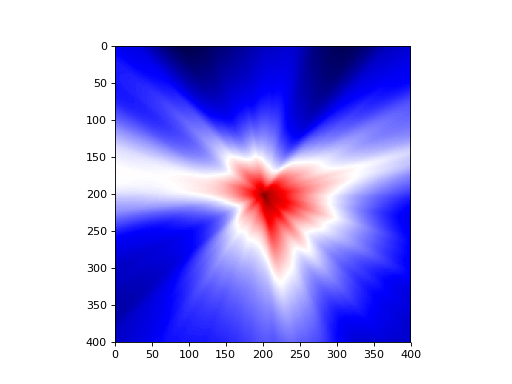

In [12]:
plt.figure()
plt.imshow((pred_2+pred_1).reshape(2*a,2*a), cmap="seismic_r")
plt.show()